# Preprocess data for FNO

## Import Packages and Data

In [1]:
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
from timeit import default_timer
import numpy as np
import xarray as xr
import glob,os,gc
from tqdm import tqdm
from util.ml import read_and_write, fourierVED, test

### Haiyan 10 Members

In [2]:
# Select member number
memb = np.arange(1,11)
# Save data in dictionary
RTHRATLW = {}
for membz in tqdm(memb):
    # Find filenames and fix order
    if membz<10:
        haiyan10_filename = sorted(glob.glob(f'/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/2024_TCG_VED_WRFsen/storage/memb0{membz}/proc/cutcart_rthratlw.pkl'))[0]
    else:
        haiyan10_filename = sorted(glob.glob(f'/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/2024_TCG_VED_WRFsen/storage/memb{membz}/proc/cutcart_rthratlw.pkl'))[0]
    
    RTHRATLW[membz] = read_and_write.depickle(haiyan10_filename)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.80it/s]


### ML

In [26]:
import importlib
importlib.reload(fourierVED)
importlib.reload(test)

<module 'util.ml.test' from '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/2024_neuralop/TC/util/ml/test.py'>

In [27]:
# Generate synthetic data with different wavenumbers
wavenumber_0 = test.generate_3d_volume(wavenumber=0)  # Constant pattern
wavenumber_1 = test.generate_3d_volume(wavenumber=1)  # Low-frequency pattern
wavenumber_2 = test.generate_3d_volume(wavenumber=2)  # Medium-frequency pattern

# Stack into a batch for testing
synthetic_data = torch.stack([wavenumber_0, wavenumber_1, wavenumber_2]).unsqueeze(1)  # Shape: (batch_size, 1, D, H, W)
print("Synthetic Data Shape:", synthetic_data.shape)

Synthetic Data Shape: torch.Size([3, 1, 32, 32, 32])


In [28]:
# Initialize FourierLayer
fourier_layer = fourierVED.FourierLayer(max_wavenumber=5)

# Pass synthetic data through the FourierLayer
with torch.no_grad():
    wavenumber_contributions = fourier_layer(synthetic_data)

print("Wavenumber Contributions:")
print(wavenumber_contributions)

Wavenumber Contributions:
tensor([[[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00]],

        [[2.5000e+00, 1.4110e-06, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00]],

        [[2.5000e+00, 7.7192e-07, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00]]])


In [32]:
# Perform Fourier transform and inspect the output
x_fft = torch.fft.rfftn(synthetic_data, dim=(-3, -2, -1), norm="forward")
x_fft_mag = torch.abs(x_fft)  # Magnitude of the Fourier coefficients

# Print a slice of the Fourier-transformed data for visual inspection
print("Fourier-transformed Magnitude (Volume 1, Slice):")
print(x_fft_mag[1, 0, :, :, 0])  # Print one slice for volume 1


Fourier-transformed Magnitude (Volume 1, Slice):
tensor([[4.4848e-20, 5.0000e-01, 4.4848e-20,  ..., 2.8198e-09, 4.4848e-20,
         5.0000e-01],
        [5.0000e-01, 0.0000e+00, 1.7371e-09,  ..., 0.0000e+00, 1.7371e-09,
         0.0000e+00],
        [4.4848e-20, 1.4949e-20, 4.4848e-20,  ..., 9.6721e-10, 4.4848e-20,
         1.0726e-08],
        ...,
        [1.1176e-08, 0.0000e+00, 2.4627e-09,  ..., 0.0000e+00, 2.4627e-09,
         0.0000e+00],
        [4.4848e-20, 1.4949e-20, 4.4848e-20,  ..., 9.6721e-10, 4.4848e-20,
         1.0726e-08],
        [5.0000e-01, 0.0000e+00, 1.7371e-09,  ..., 0.0000e+00, 1.7371e-09,
         0.0000e+00]])


In [44]:
# Generate and inspect masks for each wavenumber
D, H, W_half = synthetic_data.shape[-3], synthetic_data.shape[-2], synthetic_data.shape[-1] // 2 + 1
for k in range(1):
    mask = fourier_layer._wavenumber_mask((D, H, W_half), k)
    print(f"Wavenumber {k} Mask Sum: {mask.sum().item()}")  # Total number of elements in the mask

Wavenumber 0 Mask Sum: 8935.0


In [123]:
import numpy as np

def remove_wavenumber_signal(image, target_k, tolerance=0.1):
    """
    Removes the signal corresponding to a specific wavenumber from a 2D image.
    
    Args:
        image (numpy.ndarray): 2D array representing the image.
        target_k (float): The target wavenumber to remove.
        tolerance (float): Tolerance for matching the target wavenumber.
        
    Returns:
        numpy.ndarray: The filtered image with the target wavenumber removed.
    """
    # Compute the 2D FFT
    fft_result = np.fft.fft2(image)
    fft_shifted = np.fft.fftshift(fft_result)

    # Compute the wavenumber grid
    rows, cols = image.shape
    kx = 2 * np.pi * np.fft.fftshift(np.fft.fftfreq(Nx, ))
    ky = np.fft.fftfreq(rows) * rows
    kx, ky = np.meshgrid(kx, ky)
    k_magnitude = np.sqrt(kx**2 + ky**2)

    # Remove the target wavenumber signal
    #fft_shifted[(k_magnitude >= target_k - tolerance) & (k_magnitude <= target_k + tolerance)] = 0
    # Inverse FFT to reconstruct the filtered image
    fft_filtered = np.fft.ifftshift(fft_shifted)
    filtered_image = np.fft.ifft2(fft_filtered).real

    return filtered_image



In [127]:
import numpy as np

# Domain size and grid resolution
Lx, Ly = 10.0, 10.0  # Physical domain size in x and y
Nx, Ny = 128, 128    # Number of grid points in x and y

# Compute wavevectors
kx = 2 * np.pi * np.fft.fftshift(np.fft.fftfreq(Nx, d=Lx / Nx))
ky = 2 * np.pi * np.fft.fftshift(np.fft.fftfreq(Ny, d=Ly / Ny))

# Create 2D wavevector grid
kx_grid, ky_grid = np.meshgrid(kx, ky, indexing='ij')

# Compute wavenumber magnitude
k = np.sqrt(kx_grid**2 + ky_grid**2)

# Print example results
print(k)

[[56.86890161 56.42636245 55.98737677 ... 55.5520288  55.98737677
  56.42636245]
 [56.42636245 55.98032502 55.53781385 ... 55.09891391 55.53781385
  55.98032502]
 [55.98737677 55.53781385 55.09174843 ... 54.64926616 55.09174843
  55.53781385]
 ...
 [55.5520288  55.09891391 54.64926616 ... 54.20317185 54.64926616
  55.09891391]
 [55.98737677 55.53781385 55.09174843 ... 54.64926616 55.09174843
  55.53781385]
 [56.42636245 55.98032502 55.53781385 ... 55.09891391 55.53781385
  55.98032502]]


In [154]:
np.abs(k-1)[60:70,60:70]
#np.abs(k - k_target)[62:66,62:66]

array([[2.55430635, 2.14159265, 1.80992589, 1.59062367, 1.51327412,
        1.59062367, 1.80992589, 2.14159265, 2.55430635, 3.02320161],
       [2.14159265, 1.66572976, 1.26543468, 0.98691765, 0.88495559,
        0.98691765, 1.26543468, 1.66572976, 2.14159265, 2.66369513],
       [1.80992589, 1.26543468, 0.77715318, 0.40496295, 0.25663706,
        0.40496295, 0.77715318, 1.26543468, 1.80992589, 2.38359884],
       [1.59062367, 0.98691765, 0.40496295, 0.11142341, 0.37168147,
        0.11142341, 0.40496295, 0.98691765, 1.59062367, 2.20380845],
       [1.51327412, 0.88495559, 0.25663706, 0.37168147, 1.        ,
        0.37168147, 0.25663706, 0.88495559, 1.51327412, 2.14159265],
       [1.59062367, 0.98691765, 0.40496295, 0.11142341, 0.37168147,
        0.11142341, 0.40496295, 0.98691765, 1.59062367, 2.20380845],
       [1.80992589, 1.26543468, 0.77715318, 0.40496295, 0.25663706,
        0.40496295, 0.77715318, 1.26543468, 1.80992589, 2.38359884],
       [2.14159265, 1.66572976, 1.2654346

In [157]:
# Find indices where k is approximately 2
k_target = 7.0
tolerance = 0.5 # Adjust tolerance if needed
indices = np.argwhere(np.abs(k - k_target) < tolerance)

# Print the indices
print("Indices where k ≈ 2:")
print(indices)


Indices where k ≈ 2:
[[53 60]
 [53 61]
 [53 62]
 [53 63]
 [53 64]
 [53 65]
 [53 66]
 [53 67]
 [53 68]
 [54 58]
 [54 59]
 [54 60]
 [54 61]
 [54 67]
 [54 68]
 [54 69]
 [54 70]
 [55 57]
 [55 58]
 [55 70]
 [55 71]
 [56 56]
 [56 57]
 [56 71]
 [56 72]
 [57 55]
 [57 56]
 [57 72]
 [57 73]
 [58 54]
 [58 55]
 [58 73]
 [58 74]
 [59 54]
 [59 74]
 [60 53]
 [60 54]
 [60 74]
 [60 75]
 [61 53]
 [61 54]
 [61 74]
 [61 75]
 [62 53]
 [62 75]
 [63 53]
 [63 75]
 [64 53]
 [64 75]
 [65 53]
 [65 75]
 [66 53]
 [66 75]
 [67 53]
 [67 54]
 [67 74]
 [67 75]
 [68 53]
 [68 54]
 [68 74]
 [68 75]
 [69 54]
 [69 74]
 [70 54]
 [70 55]
 [70 73]
 [70 74]
 [71 55]
 [71 56]
 [71 72]
 [71 73]
 [72 56]
 [72 57]
 [72 71]
 [72 72]
 [73 57]
 [73 58]
 [73 70]
 [73 71]
 [74 58]
 [74 59]
 [74 60]
 [74 61]
 [74 67]
 [74 68]
 [74 69]
 [74 70]
 [75 60]
 [75 61]
 [75 62]
 [75 63]
 [75 64]
 [75 65]
 [75 66]
 [75 67]
 [75 68]]


In [124]:
# Generate a synthetic image with a single sinusoidal component at k=2
rows, cols = 256, 256
x = np.linspace(0, 2 * np.pi, cols)
y = np.linspace(0, 2 * np.pi, rows)
X, Y = np.meshgrid(x, y)

# Create a sinusoidal image
synthetic_image = np.sin(2 * X)  # Wavenumber k=2 in the x-direction

# Remove the wavenumber k=2 signal
filtered_image = remove_wavenumber_signal(synthetic_image, target_k=2, tolerance=0.1)

# Validate: The filtered image should have reduced or no signal at k=2
print("Original Image Max:", np.max(synthetic_image))
print("Filtered Image Max:", np.max(filtered_image))

Original Image Max: 0.9999810273487268
Filtered Image Max: 0.5011606687042708


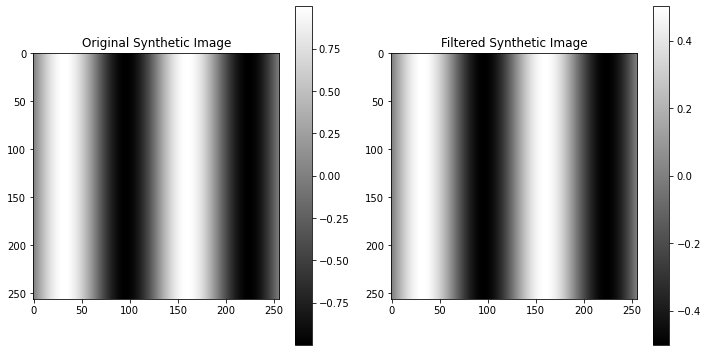

In [125]:
import matplotlib.pyplot as plt

def plot_results(original, filtered, title=""):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original " + title)
    plt.imshow(original, cmap="gray")
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.title("Filtered " + title)
    plt.imshow(filtered, cmap="gray")
    plt.colorbar()

    plt.tight_layout()
    plt.show()

# Example usage for synthetic image
plot_results(synthetic_image, filtered_image, title="Synthetic Image")
